In [12]:
import warnings
from matplotlib.ticker import MultipleLocator
import string
from prettytable import PrettyTable
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import re
import os
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import ast

In [13]:
df = pd.read_csv("../input/multilabelsongs/MultiLabelSongs_RO_prepared.csv")
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,"Nu te voi deranja niciodată, nu mă voi promite...","['Calmness', 'Sadness']"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Aici mergem ego-ul meu cel mare este gon na mă...,"['Power', 'Tension']"


In [14]:
df['labels'] = df['labels'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
df['labels'] = df['labels'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,"Nu te voi deranja niciodată, nu mă voi promite...","Calmness, Sadness"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Aici mergem ego-ul meu cel mare este gon na mă...,"Power, Tension"


In [15]:
df['labels'] = df['labels'].str.split(',\s*')
df.head(2)

,artist,genre,title,album,lyrics,labels
0,Nirvana,Rock,You Know You’re Right,Nirvana,"Nu te voi deranja niciodată, nu mă voi promite...","[Calmness, Sadness]"
1,Damian Marley,Reggae,Here We Go,Stony Hill,Aici mergem ego-ul meu cel mare este gon na mă...,"[Power, Tension]"


In [16]:
all_emotions = sorted(list(set([e for labels in df['labels'] for e in labels])))
mlb = MultiLabelBinarizer(classes=all_emotions)
labels_bin = mlb.fit_transform(df['labels'])

for i, label in enumerate(mlb.classes_):
    print(f"{i}: {label}")

0: Amazement
1: Calmness
2: Joyful activation
3: Nostalgia
4: Power
5: Sadness
6: Solemnity
7: Tenderness
8: Tension


In [17]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['lyrics'].tolist(), labels_bin, test_size=0.2, random_state=42
)

In [18]:
def evaluate(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            logits = model(input_ids, attention_mask)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.5).float()
            all_labels.append(labels.cpu())
            all_preds.append(preds.cpu())

    all_labels = torch.cat(all_labels).numpy()
    all_preds = torch.cat(all_preds).numpy()
    f1_micro = f1_score(all_labels, all_preds, average='micro')
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=all_emotions, zero_division=0)
    return f1_micro, f1_macro, precision, recall, acc, report, all_labels, all_preds

In [19]:
def plot_confusion_per_class(true_labels, pred_labels, class_names, epoch=None):
    for i, class_name in enumerate(class_names):
        cm = confusion_matrix(true_labels[:, i], pred_labels[:, i])
        plt.figure(figsize=(3.5, 3))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                    xticklabels=['Not ' + class_name, class_name],
                    yticklabels=['Not ' + class_name, class_name])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        title = f"Confusion Matrix: {class_name}"
        if epoch is not None:
            title += f" (Epoch {epoch+1})"
        plt.title(title)
        plt.tight_layout()
        plt.show()

In [20]:
class LyricsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=512):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        labels = self.labels[idx]
        encoding = self.tokenizer(text,
                                  max_length=self.max_len,
                                  padding='max_length',
                                  truncation=True,
                                  return_tensors='pt')
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.FloatTensor(labels)
        }

class MultiLabelClassificationModel(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(0.3)
        self.classifier = nn.Linear(self.model.config.hidden_size, num_labels)

    def forward(self, input_ids, attention_mask):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.last_hidden_state[:, 0]  # [CLS] token
        dropped = self.dropout(pooled_output)
        logits = self.classifier(dropped)
        return logits 

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_name = "xlm-roberta-base"
#model_name = "readerbench/RoBERT-base"
#model_name = "racai/distilbert-base-romanian-cased"
#model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = MultiLabelClassificationModel(model_name, num_labels=len(all_emotions))
model.to(device)

train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)
train_dataset = LyricsDataset(train_texts, train_labels, tokenizer)
val_dataset = LyricsDataset(val_texts, val_labels, tokenizer)

idx = 0
sample = train_dataset[idx]
original_text = train_texts[idx]
print("=== Text original ===")
print(original_text)
print("\n=== Token IDs ===")
print(sample['input_ids'])
print("\n=== Attention Mask ===")
print(sample['attention_mask'])
print("\n=== Tokens ===")
print(tokenizer.convert_ids_to_tokens(sample['input_ids']))
print("\n=== Label ===")
print(sample['labels'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

2025-06-02 18:58:54.214592: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748890734.399299      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748890734.459510      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

=== Text original ===
Imagine toate posibilitățile Imaginea toate posibilitățile sună ca o melodie de dragoste sună ca o melodie de dragoste cel mai incredibil copil, nu-l pot vedea venind pe ochii mei, așa că am primit ta să fac melodia plângând că nu pot să-i văd pe ochi, așa că am făcut ca piesa să strige că un tip bun, știu că te iubești, ca mâncare gătit, chiar dacă un nigga s-a mișcat ca un escrocher, am fost împreună cu bloc, de când am ar trebui să mă uit la prânz, de când ar trebui să mă uit la un bloc, de când am făcut față, de când ar trebui să mă uit la un bloc, de atunci Vremea rea, așa că acum călătorim clasa întâi pentru a schimba prognoza niciodată în buchete doar eu și tu mi-a plăcut punctul tău de vedere, pentru că nu ai mai ținut lovituri încă te-am lăsat luni întregi, au trecut luni de când am verificat din nou, suntem undeva într-un oraș mic, undeva, care blochează un mall în jos, cu patru ani și să-l schimbi pe armură, nu pot să înțelegi de ce vrei să-mi dai seama

In [22]:
for param in model.model.embeddings.parameters():
    param.requires_grad = True

# Freeze primele 2 layere in encoder
#for name, param in model.model.encoder.named_parameters():
#    if "layer." in name:
#        layer_num = int(name.split('.')[1])
#        if layer_num < 2:
#            param.requires_grad = False

# Calculez pos_weight pe baza distribuției claselor în train_labels
if not isinstance(train_labels, torch.Tensor):
    train_labels_tensor = torch.tensor(train_labels)
else:
    train_labels_tensor = train_labels

pos_counts = train_labels_tensor.sum(dim=0)
neg_counts = train_labels_tensor.shape[0] - pos_counts
pos_weight = neg_counts / pos_counts
print("Pos weight per class:", pos_weight)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight.to(device))
#criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-2)

Pos weight per class: tensor([4.1034, 3.8000, 2.4154, 1.6350, 1.5517, 0.9603, 2.1601, 1.3617, 1.0993])


In [23]:
train_losses = []
train_f1micros, train_f1macros, val_f1micros, val_f1macros = [], [], [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_accs, val_accs = [], []

best_model_path = "checkpoint.pt"
best_score = 0
epochs = 20

for epoch in range(epochs):
    model.train()
    total_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")

    for batch in loop:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if epoch == 0 and loop.n == 0:
            print("input_ids shape:", input_ids.shape)
            print("attention_mask shape:", attention_mask.shape)
            print("labels shape:", labels.shape)
            print("labels example:", labels[0])

        logits = model(input_ids, attention_mask)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, _, _, _ = evaluate(model, train_loader)
    train_f1micros.append(train_f1_micro)
    train_f1macros.append(train_f1_macro)
    train_precisions.append(train_prec)
    train_recalls.append(train_rec)
    train_accs.append(train_acc)

    val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, _, _, _ = evaluate(model, val_loader)
    val_f1micros.append(val_f1_micro)
    val_f1macros.append(val_f1_macro)
    val_precisions.append(val_prec)
    val_recalls.append(val_rec)
    val_accs.append(val_acc)

    val_score = val_f1_micro + val_f1_macro
    if val_score > best_score:
        best_score = val_score
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_score': best_score
        }
        torch.save(checkpoint, best_model_path)
        print("Checkpoint salvat cu succes.")
        print(f"Model salvat: Epoca {epoch+1} cu scor val total: {val_score:.4f}")

    print(f"\nEpoch {epoch+1}")
    print(f"Train -> F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}, Loss: {avg_train_loss:.4f}")
    print(f" Val  -> F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")

Epoch 1:   0%|          | 0/56 [00:00<?, ?it/s]

input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16, 9])
labels example: tensor([1., 0., 0., 0., 1., 1., 0., 0., 0.], device='cuda:0')


Epoch 1: 100%|██████████| 56/56 [00:59<00:00,  1.06s/it, loss=0.816]


Checkpoint salvat cu succes.
Model salvat: Epoca 1 cu scor val total: 0.5827

Epoch 1
Train -> F1 macro: 0.2416, F1 micro: 0.3759, Precision: 0.4021, Recall: 0.3595, Acc: 0.0023, Loss: 0.9352
 Val  -> F1 macro: 0.2231, F1 micro: 0.3595, Precision: 0.4814, Recall: 0.3391, Acc: 0.0045


Epoch 2: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.827]


Checkpoint salvat cu succes.
Model salvat: Epoca 2 cu scor val total: 0.8753

Epoch 2
Train -> F1 macro: 0.4028, F1 micro: 0.4782, Precision: 0.5162, Recall: 0.5325, Acc: 0.0045, Loss: 0.9093
 Val  -> F1 macro: 0.4004, F1 micro: 0.4749, Precision: 0.4574, Recall: 0.5251, Acc: 0.0000


Epoch 3: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.952]


Checkpoint salvat cu succes.
Model salvat: Epoca 3 cu scor val total: 1.0078

Epoch 3
Train -> F1 macro: 0.5201, F1 micro: 0.5462, Precision: 0.5025, Recall: 0.6233, Acc: 0.0124, Loss: 0.8861
 Val  -> F1 macro: 0.4839, F1 micro: 0.5239, Precision: 0.4716, Recall: 0.5676, Acc: 0.0225


Epoch 4: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.77] 


Checkpoint salvat cu succes.
Model salvat: Epoca 4 cu scor val total: 1.0701

Epoch 4
Train -> F1 macro: 0.5785, F1 micro: 0.5963, Precision: 0.5496, Recall: 0.6410, Acc: 0.0327, Loss: 0.8528
 Val  -> F1 macro: 0.5209, F1 micro: 0.5492, Precision: 0.5291, Recall: 0.5452, Acc: 0.0405


Epoch 5: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.777]


Checkpoint salvat cu succes.
Model salvat: Epoca 5 cu scor val total: 1.1178

Epoch 5
Train -> F1 macro: 0.6467, F1 micro: 0.6637, Precision: 0.5917, Recall: 0.7226, Acc: 0.0619, Loss: 0.8049
 Val  -> F1 macro: 0.5424, F1 micro: 0.5753, Precision: 0.5206, Recall: 0.5842, Acc: 0.0495


Epoch 6: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.716]



Epoch 6
Train -> F1 macro: 0.6643, F1 micro: 0.6840, Precision: 0.6290, Recall: 0.7369, Acc: 0.0709, Loss: 0.7572
 Val  -> F1 macro: 0.5358, F1 micro: 0.5804, Precision: 0.5433, Recall: 0.5752, Acc: 0.0631


Epoch 7: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.694]


Checkpoint salvat cu succes.
Model salvat: Epoca 7 cu scor val total: 1.1381

Epoch 7
Train -> F1 macro: 0.7133, F1 micro: 0.7280, Precision: 0.6799, Recall: 0.7658, Acc: 0.1419, Loss: 0.7131
 Val  -> F1 macro: 0.5492, F1 micro: 0.5888, Precision: 0.5526, Recall: 0.5654, Acc: 0.0676


Epoch 8: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.571]


Checkpoint salvat cu succes.
Model salvat: Epoca 8 cu scor val total: 1.1544

Epoch 8
Train -> F1 macro: 0.7346, F1 micro: 0.7466, Precision: 0.6872, Recall: 0.8094, Acc: 0.1430, Loss: 0.6541
 Val  -> F1 macro: 0.5606, F1 micro: 0.5937, Precision: 0.5539, Recall: 0.5941, Acc: 0.0541


Epoch 9: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.589]



Epoch 9
Train -> F1 macro: 0.7426, F1 micro: 0.7542, Precision: 0.6844, Recall: 0.8346, Acc: 0.1430, Loss: 0.6215
 Val  -> F1 macro: 0.5674, F1 micro: 0.5860, Precision: 0.5389, Recall: 0.6114, Acc: 0.0631


Epoch 10: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.533]



Epoch 10
Train -> F1 macro: 0.7719, F1 micro: 0.7774, Precision: 0.7296, Recall: 0.8310, Acc: 0.1971, Loss: 0.5889
 Val  -> F1 macro: 0.5404, F1 micro: 0.5914, Precision: 0.5522, Recall: 0.5667, Acc: 0.0856


Epoch 11: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.64] 



Epoch 11
Train -> F1 macro: 0.7875, F1 micro: 0.7930, Precision: 0.7310, Recall: 0.8632, Acc: 0.2151, Loss: 0.5564
 Val  -> F1 macro: 0.5604, F1 micro: 0.5898, Precision: 0.5489, Recall: 0.5822, Acc: 0.0901


Epoch 12: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.453]


Checkpoint salvat cu succes.
Model salvat: Epoca 12 cu scor val total: 1.1660

Epoch 12
Train -> F1 macro: 0.7978, F1 micro: 0.8039, Precision: 0.7436, Recall: 0.8836, Acc: 0.2252, Loss: 0.5197
 Val  -> F1 macro: 0.5726, F1 micro: 0.5933, Precision: 0.5528, Recall: 0.6119, Acc: 0.0405


Epoch 13: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.454]



Epoch 13
Train -> F1 macro: 0.8212, F1 micro: 0.8247, Precision: 0.7752, Recall: 0.8767, Acc: 0.2748, Loss: 0.4904
 Val  -> F1 macro: 0.5578, F1 micro: 0.5924, Precision: 0.5612, Recall: 0.5593, Acc: 0.0946


Epoch 14: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.572]



Epoch 14
Train -> F1 macro: 0.8205, F1 micro: 0.8248, Precision: 0.7753, Recall: 0.8869, Acc: 0.2703, Loss: 0.4660
 Val  -> F1 macro: 0.5563, F1 micro: 0.5822, Precision: 0.5533, Recall: 0.5705, Acc: 0.0631


Epoch 15: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.427]



Epoch 15
Train -> F1 macro: 0.8555, F1 micro: 0.8537, Precision: 0.8082, Recall: 0.9120, Acc: 0.3457, Loss: 0.4355
 Val  -> F1 macro: 0.5405, F1 micro: 0.5871, Precision: 0.5413, Recall: 0.5522, Acc: 0.0856


Epoch 16: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.412]



Epoch 16
Train -> F1 macro: 0.8656, F1 micro: 0.8636, Precision: 0.8314, Recall: 0.9065, Acc: 0.3818, Loss: 0.4220
 Val  -> F1 macro: 0.5522, F1 micro: 0.5962, Precision: 0.5703, Recall: 0.5467, Acc: 0.0901


Epoch 17: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.354]



Epoch 17
Train -> F1 macro: 0.8682, F1 micro: 0.8651, Precision: 0.8200, Recall: 0.9328, Acc: 0.3806, Loss: 0.3839
 Val  -> F1 macro: 0.5369, F1 micro: 0.5789, Precision: 0.5449, Recall: 0.5616, Acc: 0.0586


Epoch 18: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.375]



Epoch 18
Train -> F1 macro: 0.8779, F1 micro: 0.8764, Precision: 0.8514, Recall: 0.9157, Acc: 0.4403, Loss: 0.3703
 Val  -> F1 macro: 0.5360, F1 micro: 0.5667, Precision: 0.5440, Recall: 0.5426, Acc: 0.0495


Epoch 19: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.275]



Epoch 19
Train -> F1 macro: 0.9055, F1 micro: 0.8991, Precision: 0.8784, Recall: 0.9373, Acc: 0.5113, Loss: 0.3333
 Val  -> F1 macro: 0.5353, F1 micro: 0.5830, Precision: 0.5540, Recall: 0.5385, Acc: 0.0811


Epoch 20: 100%|██████████| 56/56 [00:58<00:00,  1.05s/it, loss=0.319]



Epoch 20
Train -> F1 macro: 0.9160, F1 micro: 0.9102, Precision: 0.8920, Recall: 0.9450, Acc: 0.5608, Loss: 0.3155
 Val  -> F1 macro: 0.5312, F1 micro: 0.5911, Precision: 0.5572, Recall: 0.5479, Acc: 0.0495


In [24]:
def load_model_from_checkpoint(path, model_name, num_labels, device):
    model = MultiLabelClassificationModel(model_name, num_labels)
    checkpoint = torch.load(path, map_location=device, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    return model, checkpoint['epoch'], checkpoint['best_score']


GENERAL PERFORMANCE AFTER TRAINING
Train:
F1 macro: 0.7978, F1 micro: 0.8039, Precision: 0.7436, Recall: 0.8836, Acc: 0.2252
                   precision    recall  f1-score   support

        Amazement       0.65      0.98      0.78       174
         Calmness       0.52      0.96      0.68       185
Joyful activation       0.74      0.97      0.84       260
        Nostalgia       0.67      0.81      0.74       337
            Power       0.84      0.85      0.85       348
          Sadness       0.89      0.84      0.86       453
        Solemnity       0.64      0.88      0.74       281
       Tenderness       0.90      0.90      0.90       376
          Tension       0.83      0.76      0.80       423

        micro avg       0.75      0.87      0.80      2837
        macro avg       0.74      0.88      0.80      2837
     weighted avg       0.77      0.87      0.81      2837
      samples avg       0.77      0.88      0.80      2837


Validation:
F1 macro: 0.5726, F1 micro: 0.59

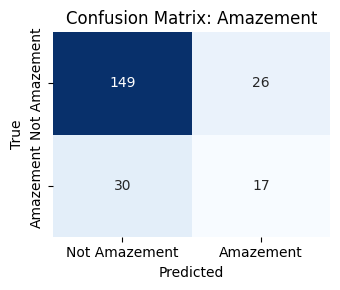

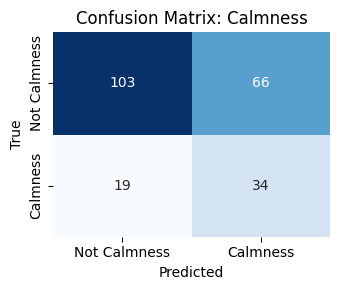

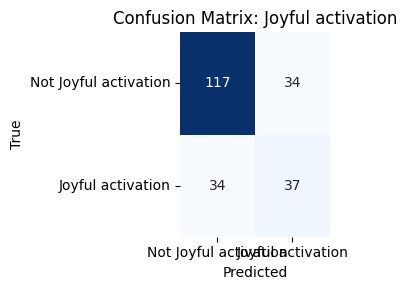

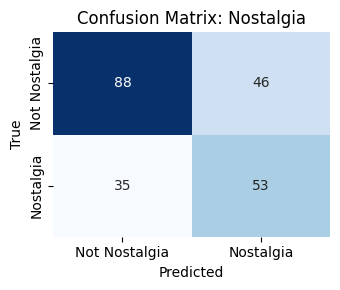

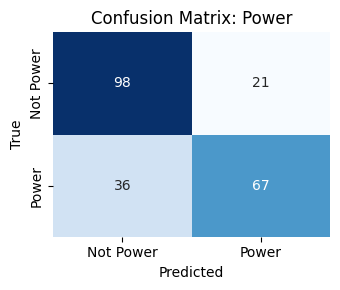

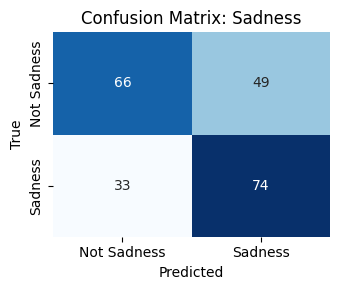

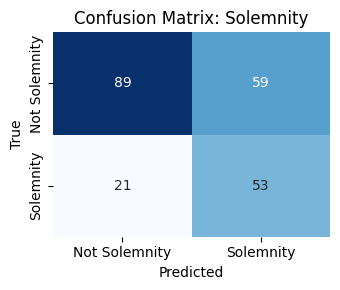

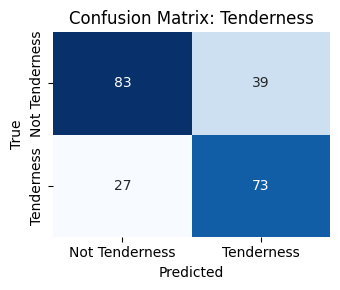

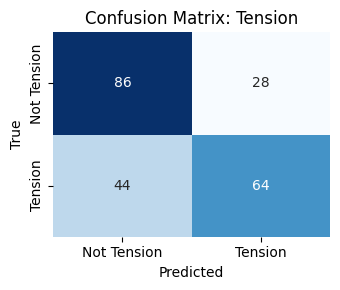

In [25]:
model_path = best_model_path

model, last_epoch, best_score = load_model_from_checkpoint(
    path=model_path,
    model_name=model_name,
    num_labels=len(all_emotions),
    device=device
)

model.eval()

train_f1_micro, train_f1_macro, train_prec, train_rec, train_acc, train_report, _, _ = evaluate(model, train_loader)
val_f1_micro, val_f1_macro, val_prec, val_rec, val_acc, val_report, val_labels, val_preds = evaluate(model, val_loader)

print("\nGENERAL PERFORMANCE AFTER TRAINING")
print("Train:")
print(f"F1 macro: {train_f1_macro:.4f}, F1 micro: {train_f1_micro:.4f}, Precision: {train_prec:.4f}, Recall: {train_rec:.4f}, Acc: {train_acc:.4f}")
print(train_report)

print("\nValidation:")
print(f"F1 macro: {val_f1_macro:.4f}, F1 micro: {val_f1_micro:.4f}, Precision: {val_prec:.4f}, Recall: {val_rec:.4f}, Acc: {val_acc:.4f}")
print(val_report)

plot_confusion_per_class(val_labels, val_preds, all_emotions)

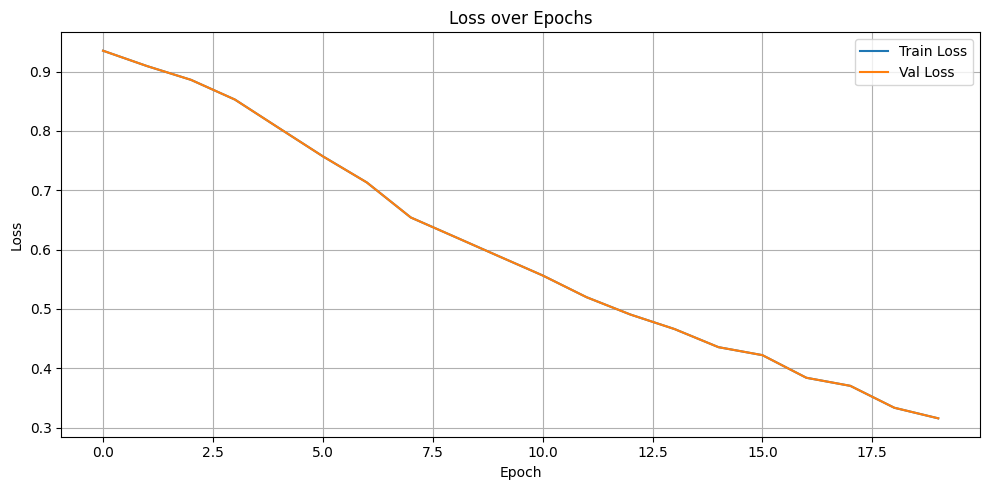

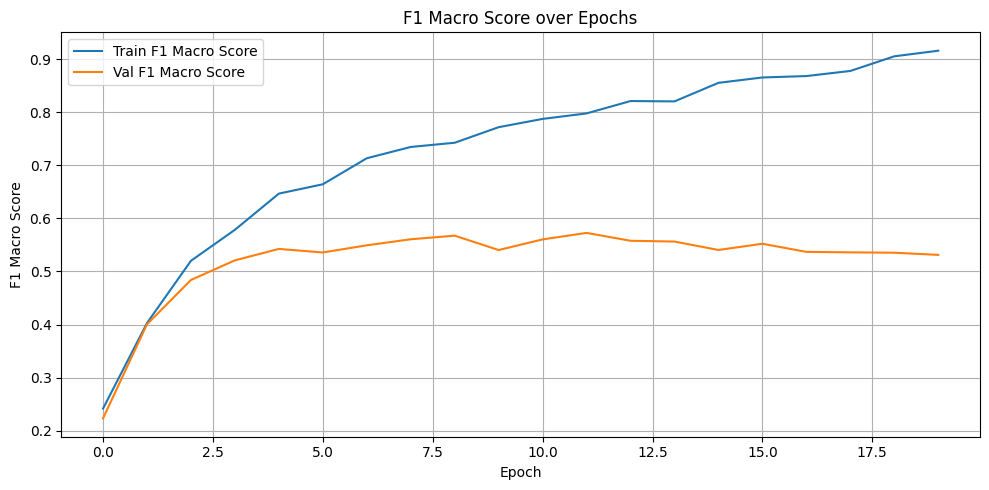

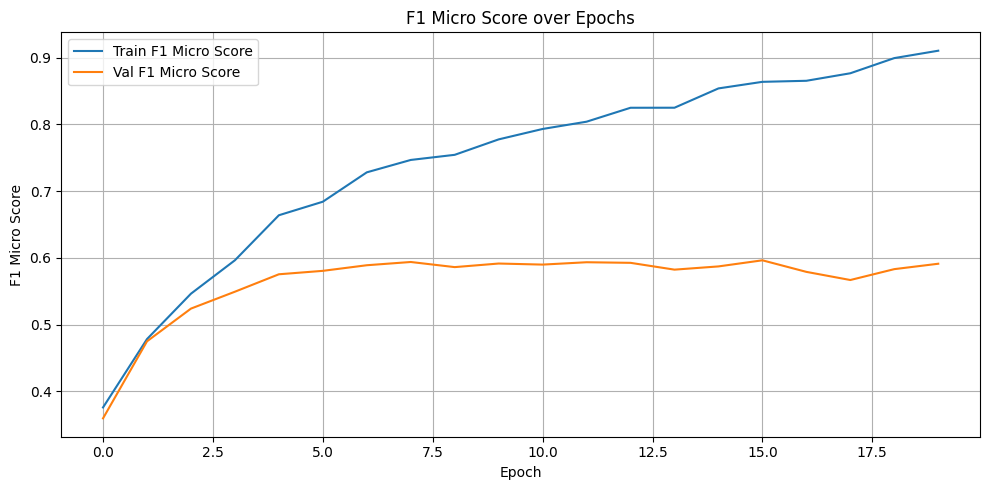

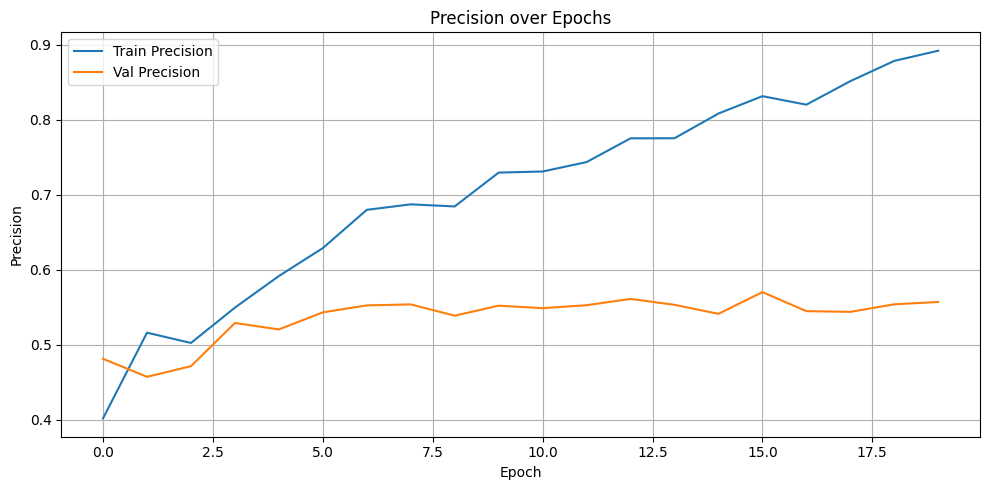

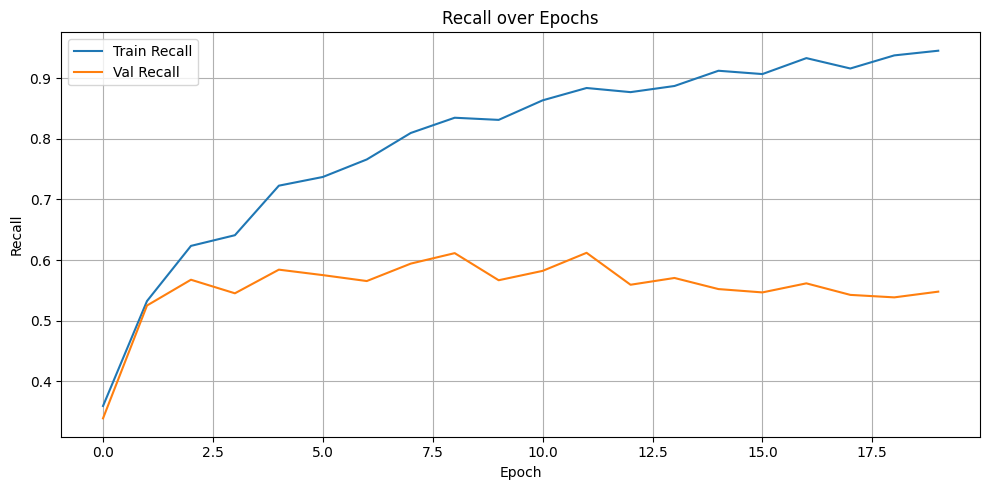

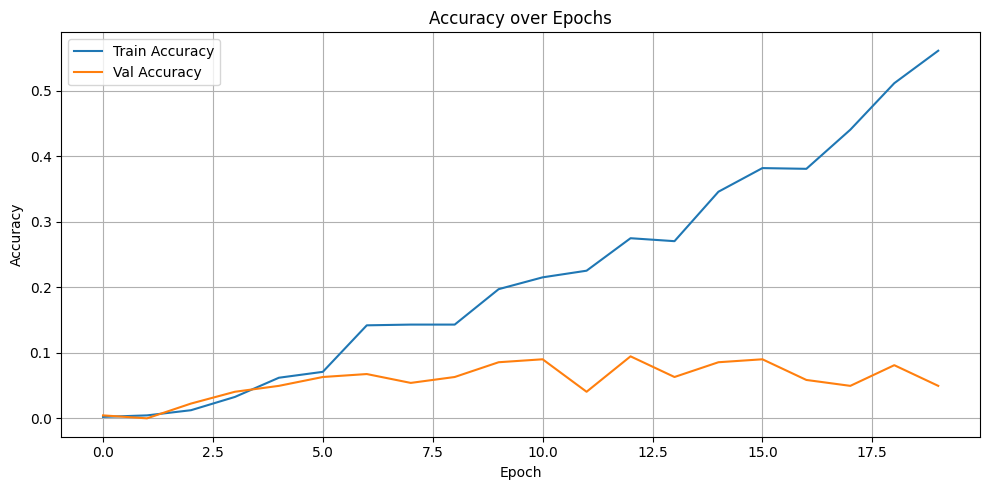

In [26]:
def plot_metrics(train, val, name):
    plt.figure(figsize=(10, 5))
    plt.plot(train, label=f'Train {name}')
    plt.plot(val, label=f'Val {name}')
    plt.xlabel("Epoch")
    plt.ylabel(name)
    plt.title(f"{name} over Epochs")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{name.lower().replace(' ', '_')}_curve.png")
    plt.show()

plot_metrics(train_losses, train_losses, "Loss")
plot_metrics(train_f1macros, val_f1macros, "F1 Macro Score")
plot_metrics(train_f1micros, val_f1micros, "F1 Micro Score")
plot_metrics(train_precisions, val_precisions, "Precision")
plot_metrics(train_recalls, val_recalls, "Recall")
plot_metrics(train_accs, val_accs, "Accuracy")

In [27]:
def predict_emotions(text, model, tokenizer, threshold=0.5):
    model.eval()
    encoding = tokenizer(text,
                         max_length=512,
                         padding='max_length',
                         truncation=True,
                         return_tensors='pt')
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        logits = model(input_ids, attention_mask)
        probs = torch.sigmoid(logits).cpu().numpy()[0]

    preds = (probs >= threshold).astype(int)
    results = {emotion: float(prob) for emotion, prob in zip(all_emotions, probs)}
    predicted_emotions = [emotion for emotion, pred in zip(all_emotions, preds) if pred == 1]
    return predicted_emotions, results

In [29]:
text_ro = "O vreme, a fost greu în ultima vreme, am fost mai bine decât în ultimele patru decembrie reci pe care mi le amintesc. Și îmi văd familia în fiecare lună. Am găsit o fată pe care o iubesc părinții mei. Vine să stea peste noapte și cred că aș putea avea totul. Și îi mulțumesc lui Dumnezeu în fiecare zi pentru fata pe care mi-a trimis-o. Dar știu lucrurile pe care mi le dă, le poate lua. Și te țin în brațe în fiecare noapte. Și acesta e un sentiment cu care vreau să mă obișnuiesc. Dar nu există bărbat mai înspăimântat ca bărbatul care riscă să te piardă."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "For a while, it's been hard lately, I've been better than I've been in the last four cold Decembers that I can remember. And I see my family every month. I found a girl that my parents love. She's coming to stay overnight and I think I could have it all. And I thank God every day for the girl he sent me. But I know the things he gives me, he can take away. And I hold you in my arms every night. And that's a feeling I want to get used to. But there's no man more scared than the man who risks losing you."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.10141889750957489, 'Calmness': 0.3673519492149353, 'Joyful activation': 0.04518963024020195, 'Nostalgia': 0.7274034023284912, 'Power': 0.05238672345876694, 'Sadness': 0.7969071269035339, 'Solemnity': 0.2262914776802063, 'Tenderness': 0.949294924736023, 'Tension': 0.1686008721590042}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.4764762222766876, 'Calmness': 0.37010622024536133, 'Joyful activation': 0.12702275812625885, 'Nostalgia': 0.7282344102859497, 'Power': 0.04709428548812866, 'Sadness': 0.6242843866348267, 'Solemnity': 0.18024305999279022, 'Tenderness': 0.9835752248764038, 'Tension': 0.06406530737876892}


In [32]:
text_ro = "Simt cum îmi bate inima cu putere, e atât de greu să mă calmez, Sunt prea răbdător? Prea cald, m-a făcut să transpir pe podea (Ooh, transpir pe podea) Pur și simplu nu mai pot suporta (Woah-woah, oh, woah; Ah) Și suntem atât de aproape, văd în ochii tăi Dacă există o șansă o să profit, te implor, te rog dă-mi un semn Aștept de prea mult timp, cred că e timpul, mm-hmm Toată magia asta arde ca un foc înăuntru Și e mult prea cald, fată, ar trebui să ne eliberăm Am așteptat să fiu lângă tine Îmi dau seama cât de mult îți dorești și tu, ooh Toată tensiunea asta, iubito, eliberează-ți corpul (Ha) Suntem doar tu și eu Ne privim in ochi in aceasta cameră aglomerată Felul în care te uiți la mine, nu pot refuza Toată tensiunea asta, iubito, eliberează-ți corpul, da, iubito Coadă de cal așezată exact cum trebuie desfa-o fată, nu Fii timida, mă bucur că am spart gheața. Hai să continuăm să dansăm (Dansăm, dansăm). Iubito, ți-o pot da cum vrei (Cum vrei)."
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("RO")
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "I feel my heart pounding, it's so hard to calm down, Am I too patient? Too hot, got me sweating on the floor (Ooh, sweating on the floor) I just can't take it anymore (Woah-woah, oh, woah; Ah) And we're so close, I see it in your eyes If there's a chance I can take it, I'm begging you, please give me a sign I've been waiting too long, I think it's time, mm-hmm All this magic burns like a fire inside And it's way too hot, girl, we should let it loose I've been waiting to be get next to you I realize how much you want it too, ooh All this tension, baby, let your body loose (Ha) It's just you and me Locking eyes inside this crowded room The way you look at me, I can't refuse All this tension, baby, let your body loose, yeah, baby let it loose, ponytail sitting just right, Let it down, girl, don't be shy, I'm just glad we broke the ice. Let's on keep dancing (Dancing, dancing). Baby, I can give it to you any way you want (Any way you want)."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("EN")
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

RO
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.21347679197788239, 'Calmness': 0.17230254411697388, 'Joyful activation': 0.21381357312202454, 'Nostalgia': 0.5952494740486145, 'Power': 0.031427040696144104, 'Sadness': 0.6304810047149658, 'Solemnity': 0.13183946907520294, 'Tenderness': 0.984718382358551, 'Tension': 0.18617719411849976}
EN
Predicted emotions: ['Nostalgia', 'Sadness', 'Tenderness']
Probabilities per emotion: {'Amazement': 0.2747969627380371, 'Calmness': 0.11002334207296371, 'Joyful activation': 0.33553367853164673, 'Nostalgia': 0.6168848872184753, 'Power': 0.038297511637210846, 'Sadness': 0.5965450406074524, 'Solemnity': 0.12448494136333466, 'Tenderness': 0.9834331274032593, 'Tension': 0.2011762112379074}


In [31]:
text_ro = "Oamenii cred că sunt mare, dar sunt mic. Nu sunt mulțumit de obiective. Mă uit la visele mele, și tot cresc. Îmi dau un nume scării, do-re-mi-fa. Puterea Regelui Uriaș e o armă, urechile mele sunt deschise. O văd în ochii mei, e toxică, capacitatea mea e atât de mare. Sunt ca o furnică lucrătoare. Dar voi depăși durerea și voi deveni un gigant. Ne numesc Dumnezeul Zeilor. Să ne folosim puterile pe care le deținem pentru propriile lor dorințe, să le privim cum explodează. Sunt cunoscut ca un gigant. Nu, nu, nu, sunt, dar neg. Avem locuri de mers, avem locuri în care să curg. Nu sunt mulțumit, îmi doresc mai mult. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, zdrobind lumi sub pământ. Sunt un gigant (Suna-mă, sună-mă, sună-mă, sună-mă, sună-mă). Sunt un gigant, trecând peste deficiențe. Aleargă, aleargă, aleargă înainte să venim, vino, vino. Ard, arde, arde, pentru că nu am terminat, gata, gata. Aleargă, aleargă, aleargă înainte să venim, vino, vino, sunt un gigant, zdrobind lumile de dedesubt"
predicted_emotions_ro, probs_ro = predict_emotions(text_ro, model, tokenizer)
print("Predicted emotions:", predicted_emotions_ro)
print("Probabilities per emotion:", probs_ro)

text_en = "People think I'm big, but I'm small. I'm not satisfied with goals. I look at my dreams, and I'm still growing. I give my ladder a name, do-re-mi-fa. The power of the Giant King is a weapon, my ears are open. I see it in my eyes, it's toxic, my capacity is so great. I'm like a worker ant. But I will overcome the pain and become a giant. I call ourselves the God of Gods. Let's use the powers we hold for our own desires, let's watch them explode. I'm known as a giant. No, no, no, I am, but I deny it. We have places to walk, we have places to flow. I'm not satisfied, I want more. I'm a giant (Call me, call me, call me, call me, call me). I'm a giant, crushing worlds underground. I'm a giant (Call me, call me, call me, Call me, call me. I'm a giant, overcoming shortcomings. Run, run, run before we come, come, come. Burn, burn, burn, because I'm not done, done, done. Run, run, run before we come, come, come, I'm a giant, crushing the worlds below."
predicted_emotions_en, probs_en = predict_emotions(text_en, model, tokenizer)
print("Predicted emotions:", predicted_emotions_en)
print("Probabilities per emotion:", probs_en)

Predicted emotions: ['Calmness', 'Power', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.02221733145415783, 'Calmness': 0.6670964956283569, 'Joyful activation': 0.05894137918949127, 'Nostalgia': 0.32914623618125916, 'Power': 0.7823246717453003, 'Sadness': 0.6588480472564697, 'Solemnity': 0.9049292206764221, 'Tenderness': 0.08387617021799088, 'Tension': 0.8066145777702332}
Predicted emotions: ['Calmness', 'Power', 'Sadness', 'Solemnity', 'Tension']
Probabilities per emotion: {'Amazement': 0.040684569627046585, 'Calmness': 0.7014836072921753, 'Joyful activation': 0.08918742835521698, 'Nostalgia': 0.2884807884693146, 'Power': 0.863004207611084, 'Sadness': 0.553846538066864, 'Solemnity': 0.9368402361869812, 'Tenderness': 0.0902811735868454, 'Tension': 0.7220203280448914}
